# Load Packages

- We use `torch`package.
- We use `pytorch_lightning` packages to simplify fitting and evaluate models.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import \
     (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

- Main library and essential tools to specify sequentially-structured networks

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

- Tools from `torchmetrics` to compute metrics to evaluate performance.
- Tools from `torchinfo` to summarize info of the layers of a model.
    - `read_image()` load test images

In [3]:
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

- `pytorch_lightning` package simplifies the specification and fitting and evaluate models by reducing amount of boilerplate code needed.
- `pytorch_lightning` is higher-level interface than `torch`.
- `pytorch_lightning` is a high-level module for fitting `torch` models

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

- `seed_everything()` set seed.
- `use_deterministic_algorithms` fix algorithms.

In [5]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


- We use datasets from `torchvision`.
- We use transforms from `torchvision` for preprocessing.
- We use a pretrained network for image classification

In [6]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize,
                                    CenterCrop, ToTensor)

- `SimpleDataModule` and `SimpleModule` from `ISLP.torch` are simple versions of objects used in `pytorch_lightning`.
- `ErrorTracker` collects targets and predictions over each mini-batch during validation or testing, enabling metric computation over the entire validation or test data set.

In [7]:
from ISLP.torch import (SimpleDataModule, SimpleModule,
                        ErrorTracker, rec_num_workers)

- We use helper functions from `ISLP.torch.imdb` to load data, lookup that maps integers to keys in data.
- We use a modified copy of the preprocessed `imdb` data from `keras`. It saves time for preprocessing.
    - `keras` is a separate package for fitting deep learning models.

In [8]:
from ISLP.torch.imdb import (load_lookup, load_tensor,
                             load_sparse, load_sequential)

- We use `glob()` from `glob` package to find all files matching wildcard characters.
- We use `json` module to load JSON file for looking up classes to identify labels of the pictures in `ResNet50`.

In [9]:
from glob import glob; import json

# MNIST
- Modified National Institute of Standards and Technology.
- A collection of handwritten digits.
- It contains 60,000 training images and 10,000 testing images.
- Each image is 28x28 = 784 pixels.
- Each pixel is an integer between 0 and 255.
- Each image is labeled with the digit it represents, from 0 to 9.
- The images are stored in a flatten format, with 784 pixels per image.

In [10]:
mnist_train = MNIST(root='data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='data', train=False, download=True, transform=ToTensor())
# mnist_train, mnist_test = [MNIST(root='data', train=train, download=True, transform=ToTensor()) for train in [True, False]]

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9912422/9912422 [00:00<00:00, 12128458.01it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28881/28881 [00:00<00:00, 306662.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1648877/1648877 [00:00<00:00, 3051284.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4542/4542 [00:00<00:00, 2400217.81it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



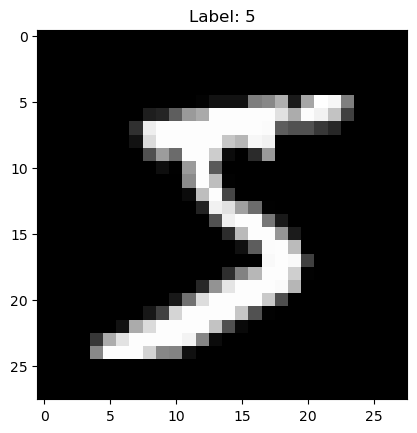

In [32]:
# Get a sample image and its label from the training set
image, label = mnist_train[0]
# Plot the image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}');

In [12]:
# Describe the training dataset
print("Training Dataset:")
print(f"Number of samples: {len(mnist_train)}")
print(f"Image shape: {mnist_train[0][0].shape}")
print(f"Labels: {set(mnist_train.targets.numpy())}")

# Describe the test dataset
print("\nTest Dataset:")
print(f"Number of samples: {len(mnist_test)}")
print(f"Image shape: {mnist_test[0][0].shape}")
print(f"Labels: {set(mnist_test.targets.numpy())}")

Training Dataset:
Number of samples: 60000
Image shape: torch.Size([1, 28, 28])
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Test Dataset:
Number of samples: 10000
Image shape: torch.Size([1, 28, 28])
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


- Neural networks are sensitive to the scale of their input data, similar to ridge and lasso regression. Therefore, we scale the pixel values to be between 0 and 1 by dividing each pixel value by 255.
- `ToTensor()` from `torchvision.transforms` package performs this rescaling automatically. It converts an image (PIL or NumPy) with pixel values [0, 255] to a PyTorch tensor with values [0, 1].
- `ToTensor()` also reorders the dimensions of the image from H x W x C to C x H x W, where C is the number of channels (1 for grayscale, 3 for RGB).
- We create a data module (_dm) from the training and test datasets, reserving 20% of the training images for validation.

In [13]:
max_num_workers = rec_num_workers()
mnist_dm = SimpleDataModule(mnist_train, mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

- We look at the data that will get fed into our network. We loop through the first two chunks of the training dataset:
    - We iterate the first two batches of the training set and display its shape.
    - Each batch size is 265 images.
    - Each image has dimensions 1 x 28 x 28. 1 channel, 28 rows, and 28 columns.

In [14]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


- We define class MINISTModel that inherits from `nn.Module`.
- Layer 1: `nn.Sequential` is a container for a sequence of layers.
    - `nn.Flatten()` flattens each 1x28x28 image into a 1x784 tensor.
    - `nn.Linear(28*28, 256)` is a fully connected layer with 784 input features and 256 output features.
    - `nn.ReLU()` is a rectified linear unit activation function.
    - `nn.Dropout(0.4)` is a dropout layer that randomly sets 40% of the input units to 0 at each update during training.
- Layer 2: `nn.Sequential` is a container for a sequence of layers.
    - `nn.Linear(256, 128)` is a layer with 256 input features and 128 output features.
    - `nn.ReLU()` and `nn.Dropout(0.3)` serve the same purpose as in the first layer.
- Forward method: combines the two layers with a final fully connected layer with 128 input features and 10 output features.
- We define a forward method of the network. It takes an input tensor `x` and passes it through the sequence of layers defined in `self_forward`.

In [15]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [16]:
mnist_model = MNISTModel()

- We verify that the model outputs the expected size using the existing batch `X_` above.

In [17]:
mnist_model(X_).size()

torch.Size([256, 10])

- We pass a tensor of correct shape. For this case, `X_` matches the expected input shape [batch_size, channel, height, width] = [256, 1, 28, 28].
- We specify the list of column names to include in the summary output.

In [18]:
summary(mnist_model, input_data=X_,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

- We use `SimpleModule.classification()` which uses the cross-entropy loss function instead of mean squared error.
    - We must supply the number of classes.
- `SimpleModule.classification()` includes an accuracy metric by default. Other classification metrics can be added from `torchmetrics`.

In [19]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

- We define a `Trainer` object to fit the model:
    - `deterministic=True` ensures reproducibility.
    - `enable_process_bar=False` suppresses the progress bar.
    - `callbacks=[ErrorTracker()]` collects targets and predictions over each mini-batch during validation or testing, enabling metric computation over the entire validation or test data set.
- To remind, we specified a validation split of 20%, so training is performed on 48,000 of 60,000 images.
- SGD uses batches of 256 observations in computing the gradient, and doing the arithmetic, we see that an epoch corresponds to 188 gradient steps.

In [20]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


- We plot the accuracy of the model on the training and validation sets across epochs.

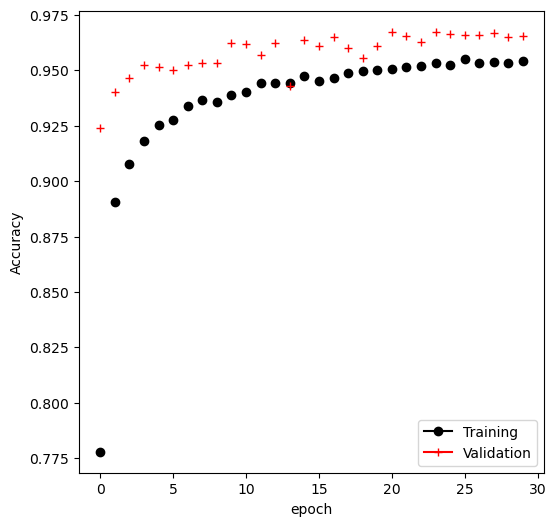

In [24]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mnist_results.plot(x='epoch', y='train_accuracy_epoch', ax=ax, label='Training', marker='o', color='k')
mnist_results.plot(x='epoch', y='valid_accuracy', ax=ax, label='Validation', marker='+', color='r')
ax.set_ylabel('Accuracy');

- We use the `predict()` method of the trainer to evaluate the model on the test data.
- The model achieves 97% accuracy on the test data.

In [25]:
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9657999873161316     │
│         test_loss         │    0.15270616114139557    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15270616114139557, 'test_accuracy': 0.9657999873161316}]

- We use `SimpleModule.classification()` to fit a logistic regression model. 
- We must first define new class for this. We simply add an input and output layer, and omit the hidden layers.

In [26]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [27]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      enable_progress_bar=False,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


In [28]:
mlr_trainer.test(mlr_module, datamodule=mnist_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9228000044822693     │
│         test_loss         │    0.3189673125743866     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3189673125743866, 'test_accuracy': 0.9228000044822693}]

- We delete some of the objects we created above.

In [26]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)